In [1]:
import findspark
findspark.init()
findspark.find()

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession,SQLContext,functions as F
from datetime import datetime
from matplotlib import pyplot as plt
import pandas as pd

conf =SparkConf().setAppName('SalesAnalysis').setMaster('local')
sc =SparkContext(conf=conf)
spark = SparkSession(sc)
sqlcontext=SQLContext(sc)

In [2]:
hostname="localhost"
dbname="python_utility"
jdbcPort="3306"
username="root"
password="qwerty@7890"
jdbcURL=f"jdbc:mysql://{hostname}:{jdbcPort}/{dbname}?user={username}&password={password}"
print(jdbcURL)


sales_df = sqlcontext.read.format('jdbc').option("url",jdbcURL).option("dbtable","sales").option("driver","com.mysql.jdbc.Driver").load()
sales_df.show(n=5)


jdbc:mysql://localhost:3306/python_utility?user=root&password=qwerty@7890
+--------------------+-------+----------+------------+-------------+----------+---------+----------+---------+---------+--------+------------+---------+-----------+
|              Region|Country|  ItemType|SalesChannel|OrderPriority| OrderDate|  OrderID|  ShipDate|UnitsSold|UnitPrice|UnitCost|TotalRevenue|TotalCost|TotalProfit|
+--------------------+-------+----------+------------+-------------+----------+---------+----------+---------+---------+--------+------------+---------+-----------+
|Middle East and N...|  Libya| Cosmetics|     Offline|            M|2014-10-18|686800706|2014-10-31|     8446|      437|  263.33|   3692590.0|2224090.0|  1468510.0|
|       North America| Canada|Vegetables|      Online|            M|2011-11-07|185941302|2011-12-08|     3018|      154|   90.93|    464953.0| 274427.0|   190526.0|
|Middle East and N...|  Libya| Baby Food|     Offline|            C|2016-10-31|246222341|2016-12-09| 

In [3]:
type(sales_df)

pyspark.sql.dataframe.DataFrame

In [4]:
sales_df.printSchema()

root
 |-- Region: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- ItemType: string (nullable = true)
 |-- SalesChannel: string (nullable = true)
 |-- OrderPriority: string (nullable = true)
 |-- OrderDate: date (nullable = true)
 |-- OrderID: integer (nullable = true)
 |-- ShipDate: date (nullable = true)
 |-- UnitsSold: integer (nullable = true)
 |-- UnitPrice: integer (nullable = true)
 |-- UnitCost: double (nullable = true)
 |-- TotalRevenue: double (nullable = true)
 |-- TotalCost: double (nullable = true)
 |-- TotalProfit: double (nullable = true)



In [5]:
sales_df.select("Country").distinct().count() #distinct countries

185

In [6]:
sales_df.select('Region').distinct().count() #7 continents

7

In [7]:
days = F.datediff(sales_df['ShipDate'],sales_df['OrderDate']) #days to deliver 

In [8]:
sales_df=sales_df.withColumn('DaysToDeliver',days) # add new col DaysToDeliver

In [9]:
sales_df.printSchema()

root
 |-- Region: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- ItemType: string (nullable = true)
 |-- SalesChannel: string (nullable = true)
 |-- OrderPriority: string (nullable = true)
 |-- OrderDate: date (nullable = true)
 |-- OrderID: integer (nullable = true)
 |-- ShipDate: date (nullable = true)
 |-- UnitsSold: integer (nullable = true)
 |-- UnitPrice: integer (nullable = true)
 |-- UnitCost: double (nullable = true)
 |-- TotalRevenue: double (nullable = true)
 |-- TotalCost: double (nullable = true)
 |-- TotalProfit: double (nullable = true)
 |-- DaysToDeliver: integer (nullable = true)



In [10]:
sales_df.select('DaysToDeliver').show(5)

+-------------+
|DaysToDeliver|
+-------------+
|           13|
|           31|
|           39|
|           32|
|           15|
+-------------+
only showing top 5 rows



In [11]:
continentsAndCountries=sales_df.groupBy('Region').agg(F.collect_set('Country'))#continents and its contries 
continentsAndCountries.show()

+--------------------+--------------------+
|              Region|collect_set(Country)|
+--------------------+--------------------+
|Middle East and N...|[Jordan, Afghanis...|
|Australia and Oce...|[Papua New Guinea...|
|              Europe|[Portugal, Italy,...|
|  Sub-Saharan Africa|[Kenya, Liberia, ...|
|Central America a...|[Haiti, Panama, B...|
|       North America|[Mexico, United S...|
|                Asia|[South Korea, Phi...|
+--------------------+--------------------+



In [12]:
ccp = continentsAndCountries.toPandas()
ccpDict = ccp.set_index('Region').to_dict()  #convert above df to dict 'Region' as Key and list as value
ccpDict=ccpDict['collect_set(Country)']
ccpDict

{'Middle East and North Africa': ['Jordan',
  'Afghanistan',
  'Bahrain',
  'Pakistan',
  'Oman',
  'Syria',
  'Morocco',
  'Saudi Arabia',
  'Somalia',
  'Lebanon',
  'Algeria',
  'United Arab Emirates',
  'Kuwait',
  'Iraq',
  'Azerbaijan',
  'Iran',
  'Libya',
  'Turkey',
  'Tunisia ',
  'Yemen',
  'Israel',
  'Egypt',
  'Qatar'],
 'Australia and Oceania': ['Papua New Guinea',
  'East Timor',
  'Tonga',
  'Palau',
  'Kiribati',
  'Tuvalu',
  'Fiji',
  'New Zealand',
  'Solomon Islands',
  'Samoa ',
  'Vanuatu',
  'Australia',
  'Nauru',
  'Federated States of Micronesia',
  'Marshall Islands'],
 'Europe': ['Portugal',
  'Italy',
  'Slovakia',
  'Finland',
  'Germany',
  'Moldova ',
  'Switzerland',
  'Hungary',
  'Greece',
  'Armenia',
  'Sweden',
  'Luxembourg',
  'Andorra',
  'Spain',
  'Georgia',
  'Belgium',
  'Cyprus',
  'Belarus',
  'Slovenia',
  'Denmark',
  'United Kingdom',
  'Russia',
  'Estonia',
  'Macedonia',
  'Montenegro',
  'Iceland',
  'Albania',
  'Liechtenstein',


In [13]:
countriesAvgDays=sales_df.groupBy('Country').avg('DaysToDeliver').sort(F.col("avg(DaysToDeliver)").desc())

#5 slowest deliviery
countriesAvgDays.show(5)

+-------------------+------------------+
|            Country|avg(DaysToDeliver)|
+-------------------+------------------+
|             Uganda|              44.6|
|Trinidad and Tobago|              42.0|
|              Malta|              40.0|
|      Liechtenstein|              40.0|
|        Saint Lucia|              39.5|
+-------------------+------------------+
only showing top 5 rows



In [14]:
cadp = countriesAvgDays.toPandas()
cadDict = cadp.set_index('Country').to_dict()  #convert above df to dict 'Country' as Key and avg as value
cadDict=cadDict['avg(DaysToDeliver)']
cadDict

{'Uganda': 44.6,
 'Trinidad and Tobago': 42.0,
 'Malta': 40.0,
 'Liechtenstein': 40.0,
 'Saint Lucia': 39.5,
 'Thailand': 38.5,
 'Canada': 36.666666666666664,
 'Ireland': 36.142857142857146,
 'Ukraine': 35.4,
 'El Salvador': 34.25,
 'Cyprus': 33.833333333333336,
 'Brunei': 33.666666666666664,
 'The Gambia': 33.5,
 'Nigeria': 33.5,
 'Panama': 33.333333333333336,
 'Maldives': 33.285714285714285,
 'Papua New Guinea': 33.25,
 'Philippines': 33.0,
 'Armenia': 32.8,
 'India': 32.6,
 'Cambodia': 32.5,
 'Moldova ': 32.42857142857143,
 'Uzbekistan': 32.4,
 'Jamaica': 32.333333333333336,
 'Mauritania': 32.0,
 'Benin': 31.75,
 'Norway': 31.571428571428573,
 'East Timor': 31.5,
 'Kazakhstan': 31.0,
 'Marshall Islands': 30.857142857142858,
 'Liberia': 30.75,
 'United Arab Emirates': 30.75,
 'Haiti': 30.6,
 'Macedonia': 30.5,
 'Indonesia': 30.333333333333332,
 'Luxembourg': 30.285714285714285,
 'Myanmar': 30.25,
 'Switzerland': 30.125,
 'Central African Republic': 29.857142857142858,
 'South Korea':

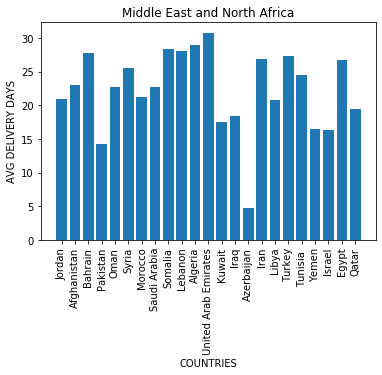

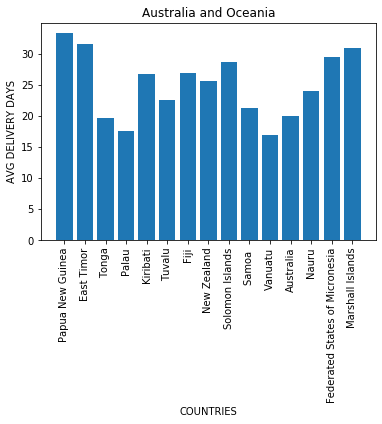

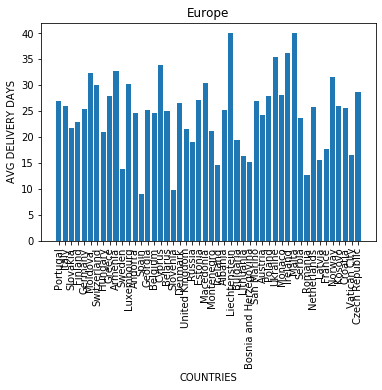

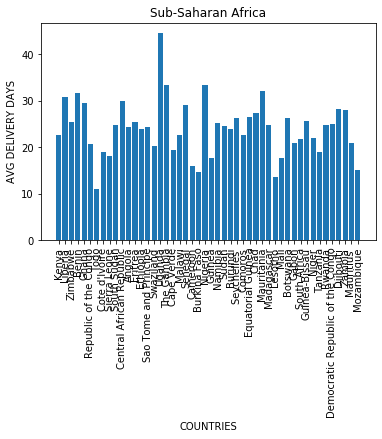

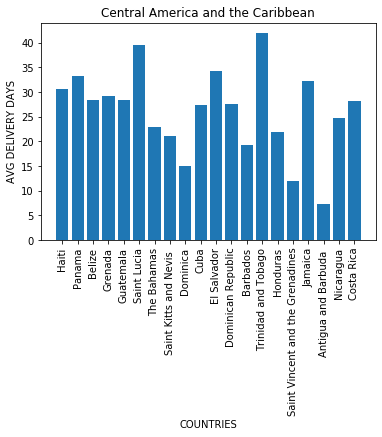

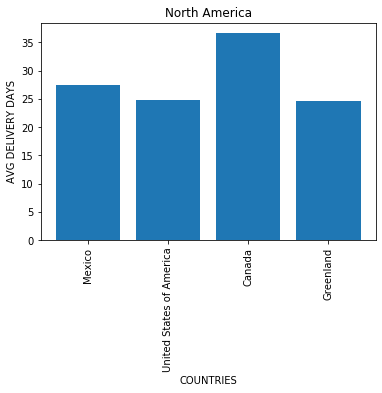

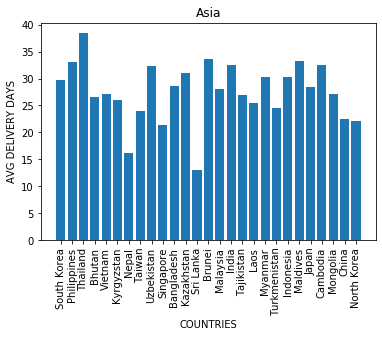

<Figure size 432x288 with 0 Axes>

In [15]:
#plotting graph based on continents
#Looking at it we can understand which country has slowest and fastest delivery

for continent in ccpDict.keys():
    x=ccpDict[continent]
    y=[]
    for country in x:
        y.append(cadDict[country])
    
    plt.bar(x,y)
    plt.title(continent)
    plt.xticks(rotation=90)
    plt.xlabel('COUNTRIES')
    plt.ylabel('AVG DELIVERY DAYS')
    plt.figure()
    

In [16]:
sales_df.groupBy('SalesChannel').count().show()

+------------+-----+
|SalesChannel|count|
+------------+-----+
|      Online|  480|
|     Offline|  520|
+------------+-----+



In [17]:
salesOnProducst=sales_df.sort('OrderDate')
salesOnProducst=salesOnProducst.groupBy('ItemType').agg(F.collect_list(F.date_format('OrderDate','yyyy')),F.collect_list( 'UnitsSold'))
salesOnProducst.show()

+---------------+------------------------------------------+-----------------------+
|       ItemType|collect_list(date_format(OrderDate, yyyy))|collect_list(UnitsSold)|
+---------------+------------------------------------------+-----------------------+
|      Baby Food|                      [2010, 2010, 2010...|   [6411, 1353, 3282...|
|         Cereal|                      [2010, 2010, 2010...|   [5132, 6241, 3322...|
|           Meat|                      [2010, 2010, 2010...|   [7110, 8086, 6569...|
|      Household|                      [2010, 2010, 2010...|   [9372, 6110, 9902...|
|     Vegetables|                      [2010, 2010, 2010...|   [4369, 7475, 3434...|
|      Beverages|                      [2010, 2010, 2010...|   [1122, 9367, 4571...|
|Office Supplies|                      [2010, 2010, 2010...|   [5668, 3131, 702,...|
|      Cosmetics|                      [2010, 2010, 2010...|   [2557, 9928, 1659...|
|  Personal Care|                      [2010, 2010, 2010...|   [2

In [18]:
sopp=salesOnProducst.toPandas()
sopDict = sopp.set_index('ItemType').to_dict()

# sopDict['collect_list(UnitsSold)']['Baby Food']

newDict=dict()

from collections import defaultdict
for x in range(len(sopp)):
    product=sopp['ItemType'][x]
    newDict[product] =defaultdict(lambda :0)
    
    for (index,value) in enumerate(sopDict['collect_list(date_format(OrderDate, yyyy))'][sopp['ItemType'][x]]):
        newDict[product][value]+=sopDict['collect_list(UnitsSold)'][product][index]

# print(newDict)

#sales of units of products in each year
for product in newDict.keys():
    print(product)
    x=list(newDict[product].keys())
    y=list(newDict[product].values())
    print(x)
    print(y)
    print('\n')
    

Baby Food
['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017']
[45395, 59137, 29543, 66951, 74188, 66813, 87391, 7200]


Cereal
['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017']
[44723, 31688, 70480, 40576, 54146, 64666, 43575, 37895]


Meat
['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017']
[57483, 52487, 88092, 38137, 51830, 32432, 47667, 39787]


Household
['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017']
[55468, 17083, 49014, 74134, 64358, 39305, 56126, 15504]


Vegetables
['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017']
[75713, 35798, 79395, 41344, 94476, 51886, 60169, 32495]


Beverages
['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017']
[72275, 59821, 65109, 86923, 106204, 28576, 42747, 43250]


Office Supplies
['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017']
[42702, 70124, 45910, 72503, 55842, 99067, 31340, 26994]


Cosmetics
['2010', '2011', '2012', '2013', '2014', '2015', '201

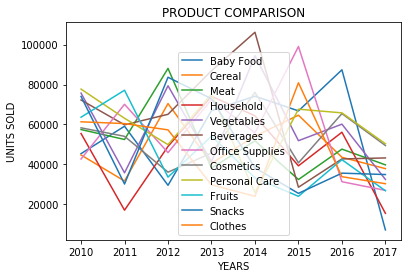

<Figure size 720x720 with 0 Axes>

In [20]:
for product in newDict.keys():
    x=list(newDict[product].keys())
    y=list(newDict[product].values())
    plt.plot(x,y,label=product)


plt.xlabel('YEARS')
plt.ylabel('UNITS SOLD')
plt.title('PRODUCT COMPARISON')
plt.legend()
plt.figure(figsize=(10,10))
plt.show()